# PINNs

Consideremos la misma ecuación diferencial, resuelta en el notebook anterior con el método de residuos de ponderación: 

$$\frac{d^2u}{dx^2} + u + x = 0 \enspace , $$

con condiciones de frontera $u(0)=u(1)=0$.

In [1]:
# Import NumPy for numerical operations
import numpy as np

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim

# Import the time module to time our training process
import time

# Import a utility module for additional plotting functions
import utils_plots

# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

La solución a este problema de valores de la frontera es:

$$u_e(x) = \frac{\sin(x)}{\sin(1)} - x \enspace .$$

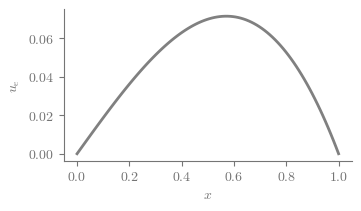

In [2]:
x = torch.linspace(0,1,100).view(-1,1)
x_physics = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)
u_e = torch.sin(x)/torch.sin(torch.tensor(1)) - x

# Create a figure for the plot
fig = plt.figure(figsize=(3.5, 2.0))

plt.plot(x,u_e,color='gray', linewidth=2)

# Set the title and labels for the x and y axes
plt.xlabel('$x$')
plt.ylabel('$u_{e}$')

# Display the plot
plt.show()

En el siguiente bloque de código, definimos nuestro modelo de red neuronal. Este modelo es una red neuronal de alimentación directa simple con dos capas ocultas, cada una conteniendo **50 neuronas**. La función de activación utilizada es la tangente hiperbólica (`tanh`). También instanciamos el modelo y definimos el optimizador (**Adam**) y la función de pérdida (**Error Cuadrático Medio**) que se utilizarán durante el entrenamiento.

In [3]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 4)
        self.layer2 = nn.Linear(4, 4)
        self.output_layer = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.output_layer(x)
        return x
    
# Create an instance of the neural network
model = NeuralNetwork()

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

En el siguiente bloque de código, entrenamos nuestra red neuronal. Ejecutamos el proceso de entrenamiento durante **2000 iteraciones**.

In [4]:
torch.manual_seed(123)

files = []
losses = []
for i in range(2_001):
    optimizer.zero_grad()
    uh = model(x_physics)
    
    # Calculate physics loss
    dudx  = torch.autograd.grad(uh, x_physics, torch.ones_like(uh), create_graph=True)[0]  # computes du/dx
    dudx2 = torch.autograd.grad(dudx, x_physics, torch.ones_like(dudx), create_graph=True)[0]  # computes d^2u/dx^2
    physics = dudx2 + uh + x_physics 
    loss_physics = loss_func(physics,torch.tensor([0.]))
    
    # Calculate boundary conditions loss
    loss_bc = loss_func(uh[0], torch.tensor([0.])) + loss_func(uh[-1], torch.tensor([0.]))
    
    # Calculate loss as the sum of phyiscs and boundary losses
    loss = loss_physics + loss_bc    
    
    # backpropagate loss
    loss.backward()
    optimizer.step()
    losses.append(loss)

    # Print progress every 1000 iterations
    #if i % 100 == 0:
    #    print(f"Iteration {i}, Loss: {loss.item()}")

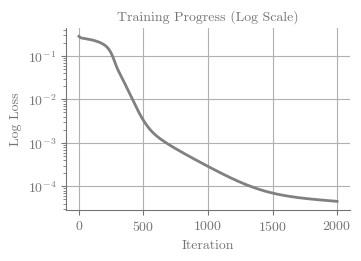

In [5]:
# Convert each tensor to a Python number
number_list = [t.item() for t in losses]

# Convert the list of numbers to a numpy array
losses = np.array(number_list)
# Create a figure for the plot
fig = plt.figure(figsize=(3.5, 2.5))

# Plot the loss values recorded during training
plt.semilogy(losses, color='gray', linewidth=2)

# Set the labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Log Loss')

# Set the title for the plot
plt.title('Training Progress (Log Scale)', fontsize=10)

# Display the grid
plt.grid(True)

# Display the plot
plt.show()

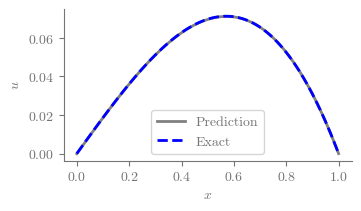

In [6]:
# Generate predictions
predictions = model(x_physics)

# Convert tensors to numpy arrays for plotting
x = x_physics.detach().numpy()
u_pred = predictions.detach().numpy()

# Create a figure for the plot
fig = plt.figure(figsize=(3.5, 2.0))

# Plot the predictions
plt.plot(x, u_pred, color='gray', linewidth=2, label='Prediction')
plt.plot(x, u_e, color='blue', linewidth=2, linestyle='dashed', label='Exact')

# Set the title and labels
plt.xlabel('$x$')
plt.ylabel('$u$')

# Add a legend
plt.legend()

# Increase the size of the plot for better visibility
plt.rcParams["figure.figsize"] = [10, 6]

# Display the plot
plt.show()